In [1]:
import pandas as pd
import wordcloud as wc
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud, get_single_color_func
import numpy as np
from random import Random
from PIL import Image
import email
import collections
from matplotlib import cm
%matplotlib inline 

## Data loading

We load the <code>Emails.csv</code> file and keep the <code>Id</code> and <code>RawText</code> columns. The <code>RawText</code> contains all the useful information for text processing tasks that we are about to perform.

In [2]:
file_name = 'hillary-clinton-emails/Emails.csv'
# load file and set Id as index
data = pd.read_csv(file_name, index_col='Id')
# keep RawText
data = data['RawText']
# drop NaN values
data = data.dropna()
data.head()

Id
1    UNCLASSIFIED\nU.S. Department of State\nCase N...
2    UNCLASSIFIED\nU.S. Department of State\nCase N...
3    UNCLASSIFIED\nU.S. Department of State\nCase N...
4    UNCLASSIFIED\nU.S. Department of State\nCase N...
5    B6\nUNCLASSIFIED\nU.S. Department of State\nCa...
Name: RawText, dtype: object

In [3]:
def format_email_text(row):
    """
    Takes an email as input and removes lines that start with specific words
    
    Parameters:
    row: email string
    return: filtered email
    """
    remove_lines = ('UNCLASSIFIED', 'U.S.', 'Case', 'Doc', 'Date:', 'STATE DEPT', 'SUBJECT', 'Cc:', 'cc:', 'To ',
                    'RELEASE', 'PART B6', 'From:', 'Sent:', 'To:', 'Subject:', 'Attachments:', 'B6', 'H:',
                    'Subject FW:', 'CONFIDENTIAL', 'For:', 'From:', 'Re:', 'PM', 'AM', 'Office:', 'SUBJECT', 
                    'Importance:', 'H', 'Fw:', 'Pis print', 'From', 'Sent from', 'Subject', 'Fwd', 'Sent', 'FULL')
    payload = row.split('\n')
    # remove lines that start or end with a word in the remove_lines list
    payload = [line for line in payload if not (line.startswith(remove_lines) or line.endswith(remove_lines))]
    payload = '\n'.join(payload)
    return payload

We start our text processing by removing lines from the email, that do not correspond to the email's useful payload.

In [4]:
# filter data Series
data = data.apply(lambda row: format_email_text(row))
data.head()

Id
1    What a wonderful, strong and moving statement ...
2    hrc memo syria aiding libya 030311.docx; hrc m...
3    Thx\nOriginal Message\nas our soldiers do. Thi...
4    B5\nB5\nFYI -\nShea, Peter T\nAll,\nADS\nAaron...
5    hrc memo syria aiding libya 030311.docx\nMarch...
Name: RawText, dtype: object

In [5]:
def filter_punctuation(text, keep_dots=False):
    """
    Removes the punctuation from each email.
    
    Parameters:
    text: string of email
    keep_dots: boolean for keeping the dots in the email (useful for separating sentences)
    return: filtered email in string
    """
    if not keep_dots:
        tokenizer = RegexpTokenizer(r'\w+')
        return " ".join(tokenizer.tokenize(text))
    tokenizer = RegexpTokenizer(r'\w+(?:\.|)')
    return " ".join(tokenizer.tokenize(text))

Then, we filter the punctuation characters from each email.

In [6]:
# filter punctuation characters from each email
data = data.apply(lambda row: filter_punctuation(row))
data.head()

Id
1    What a wonderful strong and moving statement b...
2    hrc memo syria aiding libya 030311 docx hrc me...
3    Thx Original Message as our soldiers do Thinki...
4    B5 B5 FYI Shea Peter T All ADS Aaron D Snipe S...
5    hrc memo syria aiding libya 030311 docx March ...
Name: RawText, dtype: object

In [7]:
def filter_digits(mail):
    """
    Filters all digits in a string
    
    Parameters:
    mail: email string
    return: an email string without digits
    """
    filtered_mail = []
    for word in mail.split():
        if not word.isdigit():
            filtered_mail.append(word)
    return (" ".join(filtered_mail)).strip()

We also filter all the digits from the emails, since they do not provide any information for the tasks that we are about to perform.

In [8]:
# filter digits from the emails
data = data.apply(lambda row: filter_digits(row))
data.head()

Id
1    What a wonderful strong and moving statement b...
2    hrc memo syria aiding libya docx hrc memo syri...
3    Thx Original Message as our soldiers do Thinki...
4    B5 B5 FYI Shea Peter T All ADS Aaron D Snipe S...
5    hrc memo syria aiding libya docx March This me...
Name: RawText, dtype: object

In [9]:
def convert_to_lowercase(mail):
    """
    Converts all words in the email into lower case
    
    Parameters:
    mail: email string
    return: email string to lower case
    """
    return mail.lower()

Finally, we convert the emails to lower case, since NLP tasks are case sensitive, i.e. they treat same words with capitals as different.

In [10]:
data_lowercase = data.apply(lambda row: convert_to_lowercase(row))
data_lowercase.head()

Id
1    what a wonderful strong and moving statement b...
2    hrc memo syria aiding libya docx hrc memo syri...
3    thx original message as our soldiers do thinki...
4    b5 b5 fyi shea peter t all ads aaron d snipe s...
5    hrc memo syria aiding libya docx march this me...
Name: RawText, dtype: object

In [11]:
def create_wordcloud(text, max_words=50, filter_stopwords=False, stopwords=None, plot=True):
    """
    Used to create a world cloud
    
    Parameters:
    text: string from which the words are extracted
    max_words: max number of words in the word cloud
    filter_stopwords: if True, stopwords are removed
    stopwords: set of extra stopwords
    plot: if True, the word cloud is depicted, otherwise a list of words is returned
    """
    if filter_stopwords:
        wc = WordCloud(max_words=max_words, stopwords=stopwords)
    else:
        wc = WordCloud(max_words=max_words)
        # stopwords should not be filtered, i.e. use an empty set of stopwords
        wc.stopwords = set()
    # wc objects parses the text
    wc.generate(text)
    # plot a figure
    if plot:
        plt.figure(figsize=(15,15))
        plt.imshow(wc)
        plt.axis("off")
        plt.show()
    # return a list with the most frequent words
    else:
        words = [item[0] for item in wc.words_]
        return words

## Question 1: Word Clouds


### Word Cloud without removing stopwords
We wish to build a word cloud on the whole email corpus. 

In [12]:
# build corpus from the whole dataset
corpus = ' '.join(data_lowercase.tolist())

First, we create a wordcloud **without** filtering the stopwords.

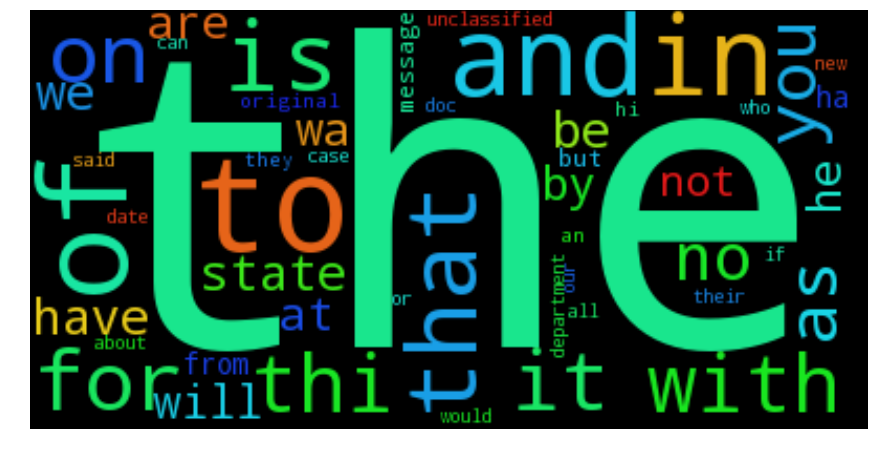

In [13]:
create_wordcloud(corpus, max_words=50)

We see that the word cloud does not reveal any useful information, since all depicted words are articles, prepositions, etc.

### Word Cloud after removing stopwords

We defice a set of stopwords to be used in the word cloud. Then, we create a word cloud **after filtering** all the stopwords from the corpus.

In [14]:
wc = WordCloud()
# create set of stopwords
stopwords = set(nltk.corpus.stopwords.words('english'))
# we add an extra stopword
stopwords.add('n\'t')

Now, we call the <code>create_wordcloud</code> function by specifying that stopwords should be filtered.

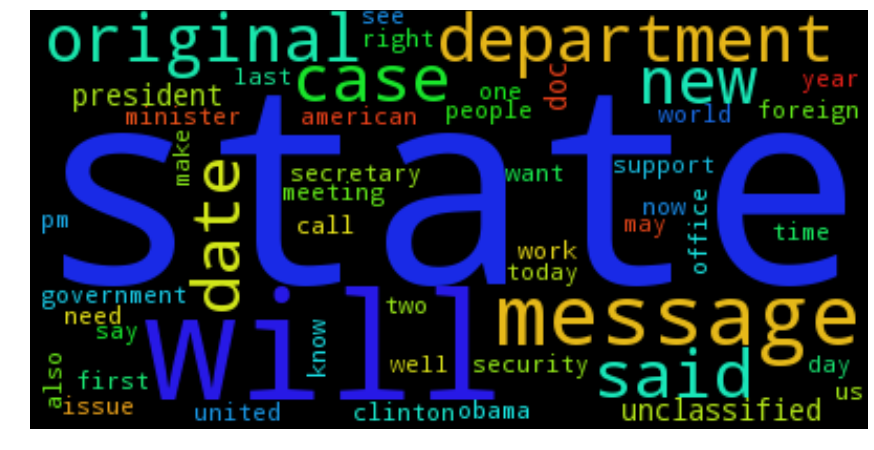

In [15]:
create_wordcloud(corpus, max_words=50, filter_stopwords=True, stopwords=None)

The results contains much more information compared to the previous word cloud. We see meaningfull words that reveal information about the email content.

### Word Cloud with stopword removal and stemming

In [16]:
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()

def stemming(mail):
    """
    Perform word stemming
    
    Parameters:
    mail: email string
    return: stemmed email string
    """
    words = [lancaster_stemmer.stem(word) for word in mail.split()]
    return " ".join(words)

We continue by performing stemming operation on the dataset. Stemming keep the trunk of each word, e.g. <code>having</code> and <code>have</code> are converted to <code>hav</code>.

In [17]:
# perform stemming
stemmed_emails = data_lowercase.apply(lambda row: stemming(row))
# build stemmed corpus
stemmed_corpus = ' '.join(stemmed_emails.tolist())

After performing the stemming operation, we build a word cloud.

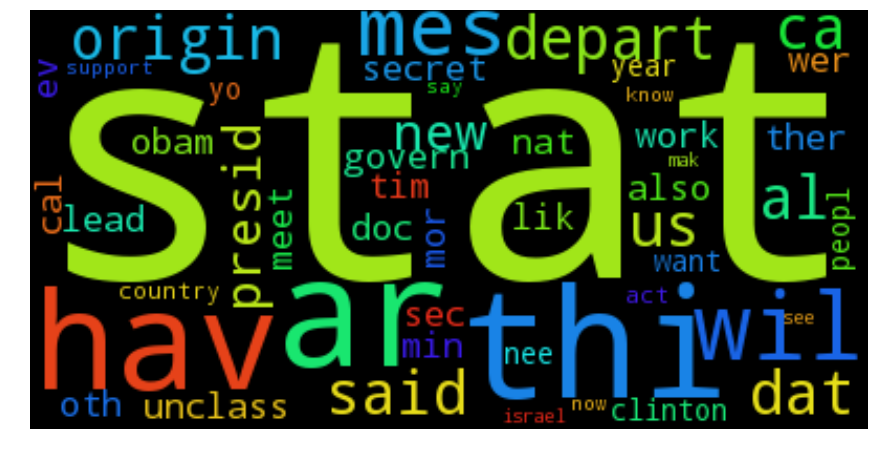

In [18]:
create_wordcloud(stemmed_corpus, max_words=50, filter_stopwords=True)

The result is very similar to the previous case. However, words are stemmed and loose their meaning.

### Word Cloud with stopword removal and Lemmatization

In [19]:
def pos_tag(mail):
    """
    Takes as input an email, performs tokenization and POS tagging
    
    Parameters:
    mail: email string
    return: a list of tuples in the form (word, pos)
    """
    mail = nltk.word_tokenize(mail)
    return nltk.pos_tag(mail)

In order to perform lemmatization, we need to perform POS tagging first.

In [20]:
# perform POS tagging
data_with_pos = data_lowercase.apply(lambda row: pos_tag(row))
data_with_pos.head()

Id
1    [(what, WP), (a, DT), (wonderful, JJ), (strong...
2    [(hrc, NN), (memo, NN), (syria, NN), (aiding, ...
3    [(thx, NN), (original, JJ), (message, NN), (as...
4    [(b5, NN), (b5, NN), (fyi, NN), (shea, NN), (p...
5    [(hrc, NN), (memo, NN), (syria, NN), (aiding, ...
Name: RawText, dtype: object

In [21]:
from nltk.corpus import wordnet as wn

def is_noun(tag):
    """
    Return true if given tag is noun
    """
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']

def is_verb(tag):
    """
    Return true if given tag is verb
    """
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

def is_adverb(tag):
    """
    Return true if given tag is adverb
    """
    return tag in ['RB', 'RBR', 'RBS']

def is_adjective(tag):
    """
    Return true if given tag is adjective
    """
    return tag in ['JJ', 'JJR', 'JJS']

def penn_to_wn(tag):
    """
    Convert given tag to a valid WordNet tag
    """
    if is_adjective(tag):
        return wn.ADJ
    elif is_noun(tag):
        return wn.NOUN
    elif is_adverb(tag):
        return wn.ADV
    elif is_verb(tag):
        return wn.VERB
    return None

In [22]:
def replace_pos_labels(row):
    """
    Replace POS tags in a row with valid WordNet tags
    
    Parameters:
    row: list of tuples (word, POS)
    return: a list of tuples with valid WordNet POS tags
    """
    for i in range(len(row)):
        # keep tag and convert it to a valid WordNet tag
        word_and_pos = list(row[i])
        word_and_pos[1] = penn_to_wn(word_and_pos[1])
        row[i] = word_and_pos
    return row

In [23]:
# replace POS with valid WordNet POS tags
data_wn_pos = data_with_pos.apply(lambda row: replace_pos_labels(row))
data_wn_pos.head()

Id
1    [[what, None], [a, None], [wonderful, a], [str...
2    [[hrc, n], [memo, n], [syria, n], [aiding, v],...
3    [[thx, n], [original, a], [message, n], [as, N...
4    [[b5, n], [b5, n], [fyi, n], [shea, n], [peter...
5    [[hrc, n], [memo, n], [syria, n], [aiding, v],...
Name: RawText, dtype: object

In [24]:
def lemmatize_email(row, lmt):
    """
    Performs lemmatization for the given row
    
    Parameters:
    row: list of tuples (word, POS)
    return: string of lemmatized email
    """
    lemmatized_row = []
    for [word, pos] in row:
        try:
            # perform lemmatization, if pos exists
            lem_word = lmt.lemmatize(word, pos=pos)
            lemmatized_row.append(lem_word)
        except:
            # return given word, if pos does not exist
            lemmatized_row.append(word)
    lem_mail = ' '.join(lemmatized_row)
    return lem_mail

Now, we perform lemmatization for each email.

In [25]:
lmt = nltk.stem.WordNetLemmatizer()
# apply lemmatization
lemmatized_emails = data_wn_pos.apply(lambda row: lemmatize_email(row, lmt))
lemmatized_emails.head()

Id
1    what a wonderful strong and move statement by ...
2    hrc memo syria aid libya docx hrc memo syria a...
3    thx original message as our soldier do think o...
4    b5 b5 fyi shea peter t all ad aaron d snipe sp...
5    hrc memo syria aid libya docx march this memo ...
Name: RawText, dtype: object

In [26]:
# build lemmatized corpus
lemmatized_corpus = ' '.join(lemmatized_emails.tolist())

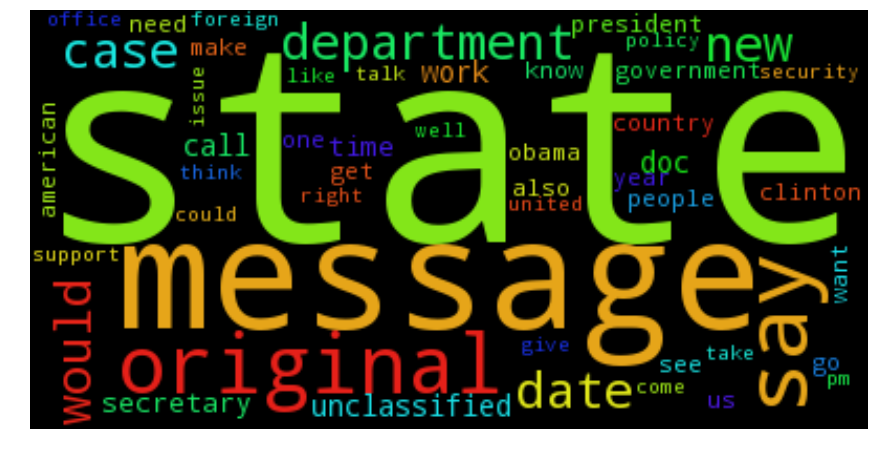

In [27]:
# create word cloud for lemmatized corpus
create_wordcloud(lemmatized_corpus, max_words=50, filter_stopwords=True, stopwords=stopwords)

We see that the resulting word cloud is similart to the word cloud achieved using stopwords elimination. However, only the **stem of each word is kept**, e.g. <code>said</code> is converted to <code>say</code>.

## Question 2: Perform Sentiment Analysis and group by Country

In [28]:
import pycountry

We load once again the <code>>Emails.csv</code> file, since we want to perform slightly different text preprocessing.

In [29]:
file_name = 'hillary-clinton-emails/Emails.csv'
data = pd.read_csv(file_name, index_col='Id')
data = data['RawText']
data = data.dropna()

Once again, we filter rows that are not useful email payload, digits and punctuation. However, we keep the dots, since they are useful in separating sentences.

In [30]:
data = data.apply(lambda row: format_email_text(row))
data = data.apply(lambda row: filter_punctuation(row, keep_dots=True))
data = data.apply(lambda row: filter_digits(row))
data.head()

Id
1    What a wonderful strong and moving statement b...
2    hrc memo syria aiding libya 030311. docx hrc m...
3    Thx Original Message as our soldiers do. Think...
4    B5 B5 FYI Shea Peter T All ADS Aaron D. Snipe ...
5    hrc memo syria aiding libya 030311. docx March...
Name: RawText, dtype: object

In [31]:
def assign_country_to_mail(mail):
    """
    Checks the email payload and finds which countries are mentioned and how often
    
    Parameters:
    mail: email string
    return: a collections.Counter() object: {key = country, value = number of occurences in the text}
    """
    countries_per_email = collections.Counter()
    # split email tokens
    tokens = mail.split()
    # for each token, check some conditions
    for token in tokens:
        # possible alpha_2 code - should not be in the stopwords, e.g. US may be capitalized us and not USA
        if len(token) == 2 and token.isupper() and token.lower() not in stopwords:
            # check if token is a country
            try:
                country = pycountry.countries.get(alpha_2 = token)
                # increment counter for country key
                countries_per_email[country.alpha_2] += 1
            except:
                pass
        # possible alpha_3 code - should not be in the stopwords, e.g. AND may be capitalized and and not Andorra
        elif len(token) == 3 and token.isupper() and token.lower() not in stopwords:
            # check if token is a country
            try:
                country = pycountry.countries.get(alpha_3 = token)
                # increment counter for country key
                countries_per_email[country.alpha_2] += 1
            except:
                pass
        # special case for Syria, as it not recognised by pycountry, when Syria is given as country name
        elif token.lower == 'syria':
            countries_per_email['SY'] += 1
        # possible country name
        else:
            try:
                country = pycountry.countries.get(name = token.title())
                # increment counter for country key
                countries_per_email[country.alpha_2] += 1
            except:
                pass
    # return NaN if dict is empty
    if len(countries_per_email) == 0:
        return np.nan
    return countries_per_email

We convert our <code>data</code> from <code>Series</code> to <code>DataFrame</code> to include some extra columns.

In [32]:
email_countries = data.to_frame()
# add countries column
email_countries['Countries'] = ''
email_countries.head()

,RawText,Countries
Id,,
1,What a wonderful strong and moving statement b...,
2,hrc memo syria aiding libya 030311. docx hrc m...,
3,Thx Original Message as our soldiers do. Think...,
4,B5 B5 FYI Shea Peter T All ADS Aaron D. Snipe ...,
5,hrc memo syria aiding libya 030311. docx March...,


Now, we call the <code>assign_country_to_mail</code> function to find all countries mentioned in each email.

In [33]:
email_countries['Countries'] = email_countries.apply(lambda row: assign_country_to_mail(row['RawText']), axis=1)

We remove rows that do not have any country assigned since they cannot be used in the aggregation that we perform later.

In [34]:
email_countries.dropna(subset=['Countries'], inplace=True)
email_countries.head()

,RawText,Countries
Id,,
2,hrc memo syria aiding libya 030311. docx hrc m...,"{'FR': 2, 'ES': 1, 'EG': 4, 'LY': 5, 'SD': 1, ..."
5,hrc memo syria aiding libya 030311. docx March...,"{'FR': 2, 'ES': 1, 'EG': 4, 'IL': 1, 'SD': 1, ..."
7,Anti Muslim film director in hiding following ...,"{'IQ': 1, 'LY': 3, 'AF': 1, 'EG': 3}"
8,hrc memo Syria aiding libya 030311. docx March...,"{'FR': 2, 'ES': 1, 'EG': 4, 'LY': 4, 'SD': 1, ..."
9,FYI Don t know if you guys have seen this but ...,{'LY': 11}


In [35]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize

def sentiment_score(email):
    """
    Perform sentiment analysis per email
    
    Parameters:
    email: email string
    return: normalized sentiment score per email
    """
    # tokenize in sentences
    sentences = tokenize.sent_tokenize(email)
    sid = SentimentIntensityAnalyzer()
    # variables used for sentiment normalization
    total_comp = 0
    count_sent = 0
    for sentence in sentences:
        count_sent += 1
        # find polarity scores per sentence
        ss = sid.polarity_scores(sentence)
        # keep the compound score
        total_comp += ss['compound']
    # normalize score
    total_comp /= count_sent
    return total_comp

We continue by calculating the sentiment score for each email.

In [36]:
email_countries['sentiment'] = email_countries.apply(lambda row: sentiment_score(row['RawText']), axis=1)
email_countries.head()

,RawText,Countries,sentiment
Id,,,
2,hrc memo syria aiding libya 030311. docx hrc m...,"{'FR': 2, 'ES': 1, 'EG': 4, 'LY': 5, 'SD': 1, ...",0.055160
5,hrc memo syria aiding libya 030311. docx March...,"{'FR': 2, 'ES': 1, 'EG': 4, 'IL': 1, 'SD': 1, ...",0.058735
7,Anti Muslim film director in hiding following ...,"{'IQ': 1, 'LY': 3, 'AF': 1, 'EG': 3}",-0.205557
8,hrc memo Syria aiding libya 030311. docx March...,"{'FR': 2, 'ES': 1, 'EG': 4, 'LY': 4, 'SD': 1, ...",0.061410
9,FYI Don t know if you guys have seen this but ...,{'LY': 11},0.122007


We see that some emails may mention more than one countries. Therefore, we have to create a new data frame that contains multiple rows with the same email, but with different countries. In that way, we can perform an efficient <code>groupby</code> operation later on.

In [37]:
pairs = []
# iterate through all rows
for _, row in email_countries.iterrows():
    # for all values in the dict, create a pair of (mail, country, sentiment score)
    for country, value in row["Countries"].items():
        pairs.append((row['RawText'], country, row['sentiment']))
# create a new dataframe from the pairs list
df = pd.DataFrame(pairs, columns=['mail', 'country', 'sentiment'])
df.head()

,mail,country,sentiment
0,hrc memo syria aiding libya 030311. docx hrc m...,FR,0.05516
1,hrc memo syria aiding libya 030311. docx hrc m...,ES,0.05516
2,hrc memo syria aiding libya 030311. docx hrc m...,EG,0.05516
3,hrc memo syria aiding libya 030311. docx hrc m...,LY,0.05516
4,hrc memo syria aiding libya 030311. docx hrc m...,SD,0.05516


We perform a <code>groupby</code> operation to count the emails per country.

In [38]:
emails_by_country = df.groupby(by='country')['mail'].count()

We keep only the countries that are mentioned in more than 150 mails.

In [39]:
top_mentioned_countries = emails_by_country[emails_by_country > 150].index
df = df[df['country'].isin(top_mentioned_countries)]

Now, we perform a <code>groupby</code> operation to aggregate the sentiment score for each county.

In [40]:
# count mails per country, used later for normalization
emails_by_country = df.groupby(by='country')['mail'].count()
# find total sentiment score per country
sentiment_by_country = df.groupby(by='country')['sentiment'].sum()

We need to normalize the aggregated sentiment score per country, using the number of mails per country.

In [41]:
# normalize sentiment score by dividing with the number of emails per country
sentiment_by_country = sentiment_by_country.divide(emails_by_country)
sentiment_by_country.head()

country
AF    0.059655
CA    0.100548
CN    0.121122
ES    0.037600
FM    0.137448
dtype: float64

Now, we create a <code>dataframe</code> that contains alla useful information, i.e. country, sentiment score and number of email for each country.

In [42]:
sentiment_by_country = sentiment_by_country.to_frame()
sentiment_by_country['numEmails'] = emails_by_country[top_mentioned_countries]
sentiment_by_country = sentiment_by_country.reset_index()
sentiment_by_country.columns = ['country', 'sentiment', 'mails']
sentiment_by_country.head()

,country,sentiment,mails
0,AF,0.059655,418
1,CA,0.100548,156
2,CN,0.121122,306
3,ES,0.037600,188
4,FM,0.137448,223


Finally, we create a bar plot. The <code>x-axis</code> contains the country labels. The height of the bar indicates the number of emails for each country. The color of each bar indicates the sentiment score for each country.

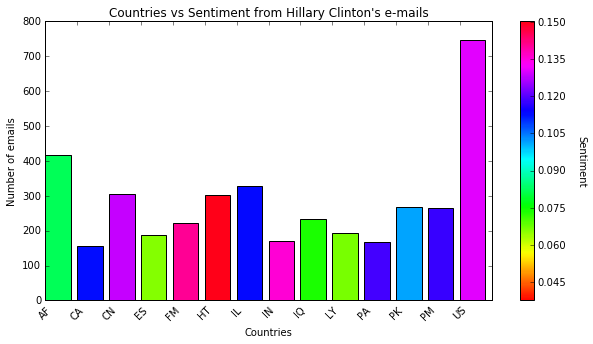

In [43]:
import matplotlib
# use country IDs for x ticks
labels = sentiment_by_country.country.values
# build the colormap based on the sentiment score
index = np.arange(len(sentiment_by_country))
color_data = sentiment_by_country.sentiment.values
colors = matplotlib.cm.hsv(color_data / float(max(color_data)))
plt.figure(figsize=(10,5))
plot = plt.scatter(color_data, color_data, c = color_data, cmap = 'hsv')
plt.clf()
# plot the colorbar
colorbar = plt.colorbar(plot)
colorbar.set_label('Sentiment', rotation=270, labelpad=20)
# plot the bars
plt.bar(index, sentiment_by_country.mails, color = colors)
plt.xticks(index, labels, rotation=45)
plt.title('Countries vs Sentiment from Hillary Clinton\'s e-mails')
plt.xlabel('Countries')
plt.ylabel('Number of emails')
plt.show()

## Question 3: Topic Modeling

Here, we are going to perform topic modeling. In order to do that, we have to perform some text processing operations. More concretely, our operations are:
* stopword filtering
* word stemming

In [44]:
import gensim

C:\Users\admin\Anaconda3\lib\site-packages\gensim\utils.py:840: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\admin\Anaconda3\lib\site-packages\gensim\utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [45]:
def stopword_filtering(row):
    """
    Filters stopwords in the row
    
    Parameters:
    row: email string
    return: list of words in row without stopwords
    """
    row = row.split()
    filtered_row = [word for word in row if word not in stopwords]
    return filtered_row

In [46]:
# convert data to lower case
data_lowercase = data_lowercase.apply(lambda row: stopword_filtering(row))

In [47]:
from nltk.stem.porter import PorterStemmer

def stem_doc(row):
    """
    Stems words in row
    
    Parameters:
    row: email string
    return: list of stemmed words
    """
    p_stemmer = PorterStemmer()
    # stem words
    words = [p_stemmer.stem(word) for word in row]
    return words

In [48]:
# stem words in emails
data_lowercase = data_lowercase.apply(lambda row: stem_doc(row))
data_lowercase.head()

Id
1    [wonder, strong, move, statement, boss, pleas,...
2    [hrc, memo, syria, aid, libya, docx, hrc, memo...
3    [thx, origin, messag, soldier, think, pat, eve...
4    [b5, b5, fyi, shea, peter, ad, aaron, snipe, s...
5    [hrc, memo, syria, aid, libya, docx, march, me...
Name: RawText, dtype: object

In [49]:
# create a list of texts
texts = data_lowercase.values.tolist()

We build a dictionary using our email corpus located in the <code>texts</code> variable.

In [50]:
from gensim import corpora, models
# build dictionary using all emails
dictionary = corpora.Dictionary(texts)

The corpus is build using the <code>dictionary.doc2bow</code> function that converts the words into tuples of the form <code>(word_id, word occurence in the sentence)</code>.

In [51]:
# build corpus
corpus = [dictionary.doc2bow(text) for text in texts]
# print some values
corpus[0][0:5]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]

In [52]:
def print_topics(ldamodel, num_topics, num_words, print_on_screen=False):
    """
    Performs topic modeling on a corpus
    
    Parameters:
    ldamodel: Lda model object
    num_topics: number of topics to look for
    num_words: number of words to describe each topic
    prin_on_screen: if True, the results are printed on the screen. By default, results are stored in files
    """
    f = open('./topics/topics_' + str(num_topics) + '.txt', 'w')
    # print the words related to each topic
    topics = ldamodel.print_topics(num_topics=num_topics, num_words=10)
    topics = [topic for topic in topics]
    # for each topic, create a nice and understandable output
    for topic in topics:
        message = ''
        message += 'Topic ' + str(topic[0]) + ':\n'
        topic_words = []
        for item in topic[1:]:
            words = topic[1].split('+')
            for item in words:
                w = item.split('*')[1]
                topic_words.append(w)
        message += ' | '.join(topic_words) + '\n'
        if print_on_screen:
            print('Topic ', topic[0], ':')
            print(message)
        f.write(message)
    f.close()

Finally, we perform topic modeling on the corpus.

In [53]:
# peform topic modeling for certain number of topics
for num_of_topics in range(5,55,5):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_of_topics, id2word = dictionary, passes=5)
    print_topics(ldamodel, num_of_topics, 10)

We load and print a file with successful and almost clear topic division.

In [54]:
with open('./topics/topics_10.txt', 'r') as input_file:
    for line in input_file:
        print(line, end='')

Topic 0:
"pm"  | "secretari"  | "offic"  | "depart"  | "state"  | "meet"  | "w"  | "room"  | "arriv"  | "en"
Topic 1:
"parti"  | "deal"  | "uk"  | "said"  | "co"  | "brown"  | "power"  | "tori"  | "blair"  | "gordon"
Topic 2:
"de"  | "thoma"  | "state"  | "u"  | "hondura"  | "zelaya"  | "f"  | "depart"  | "elect"  | "blog"
Topic 3:
"state"  | "govern"  | "develop"  | "u"  | "countri"  | "peopl"  | "work"  | "world"  | "nation"  | "unit"
Topic 4:
"state"  | "gov"  | "call"  | "j"  | "secretari"  | "abedin"  | "messag"  | "mill"  | "huma"  | "cheryl"
Topic 5:
"state"  | "u"  | "depart"  | "case"  | "unclassifi"  | "f"  | "date"  | "doc"  | "offic"  | "b"
Topic 6:
"messag"  | "origin"  | "call"  | "know"  | "work"  | "want"  | "state"  | "see"  | "thank"  | "talk"
Topic 7:
"al"  | "govern"  | "sourc"  | "libya"  | "attack"  | "secur"  | "state"  | "minist"  | "forc"  | "libyan"
Topic 8:
"israel"  | "isra"  | "palestinian"  | "state"  | "peac"  | "arab"  | "netanyahu"  | "settlement"  | "n

From the key words of each topic, we can identify a topic title. Thus we have:

* Topic 0: meeting arrangements (key words: office, meeting, meet, arrive)
* Topic 1: UK (key words: UK, Brown, Blair)
* Topic 2: Elections in Hondura (key words: Hondura, Zelaya, elect)
* Topic 3: Not so clear
* Topic 4: House Benghazi Committee testimony (key words: Huma Abedin, Cheryl Mills)
* Topic 5: Unclassified documents (key words: unclassified, doc, date, doc)
* Topic 6: Not
* Topic 7: Situation in Libya (key words: attack, secure, force, libyan)
* Topic 8: Negotiation with Israel (key words: palestinian, negotiate, Netanyahu)
* Topic 9: Discussion around Obama (key words: said, say, clinton)
    

The more topics we choose to model, the finer the details are. You can see all resulting topics in the <code>topics directory</code>. In cases, where lots of topics are used (e.g. topics greater than 20), it becomes easy to identify a general topic, however, it is possible that another topic describes pretty much the same thing. For example, when 40 topics are used, topics 30 and 33 both talk about Libya.

## Question 4: Bonus

### Communications Graph

We start by loading the <code>Emails</code> datase and keep information regarding the email senders and receivers. Moreover, we keep the email id. To make the bonus part easier, we do not take the <code>ExtractedCc</code> field into account. However, we know that this field contains communication information.

In [55]:
file_name = 'hillary-clinton-emails/Emails.csv'
emails = pd.read_csv(file_name)
# keep necessary columns
emails = emails [['Id', 'MetadataTo', 'SenderPersonId']]
emails.fillna(value='', inplace=True)
emails.head()

,Id,MetadataTo,SenderPersonId
0,1,H,87
1,2,H,
2,3,;H,32
3,4,H,32
4,5,"Abedin, Huma",80


We continue by loading the <code>Aliases</code> dataset that contains all possible usernames for each person. Each username is related to a person ID.

In [56]:
file_name = 'hillary-clinton-emails/Aliases.csv'
alias = pd.read_csv(file_name)

Then, we load the <code>EmailReceivers</code> dataset that contains the receiver ID for each email.

In [57]:
file_name = 'hillary-clinton-emails/EmailReceivers.csv'
receivers = pd.read_csv(file_name)

Finally, we load the <code>Persons</code> dataset that contains a mapping between person ID and name.

In [58]:
file_name = 'hillary-clinton-emails/Persons.csv'
persons = pd.read_csv(file_name, index_col='Id')

In [59]:
emails.set_index('Id', inplace=True)

We use the <code>receivers</code> dataframe to find the receiver for each email. This, we fill the <code>MetadataTo</code> column.

In [60]:
emails['MetadataTo'] = receivers['PersonId']
emails.head()

,MetadataTo,SenderPersonId
Id,,
1,80,87
2,228,
3,80,32
4,80,32
5,81,80


We remove emails that have a <code>NaN</code> value in the <code>SenderPersonId</code> column, i.e. emails whose sender is unknown.

In [61]:
emails = emails[emails['SenderPersonId']!='']

In [62]:
def convert_id_to_name(row):
    """
    Replace person IDs with names
    
    Parameters:
    row: row of dataframe
    return: new row with names instead of IDs
    """
    row['MetadataTo'] = persons.ix[row['MetadataTo'], 'Name']
    row['SenderPersonId'] = persons.ix[row['SenderPersonId'], 'Name']
    return row

We match the person IDs to their real names using the <code>persons</code> dataframe.

In [63]:
emails = emails.apply(lambda row: convert_id_to_name(row), axis=1)
emails.head()

,MetadataTo,SenderPersonId
Id,,
1,Hillary Clinton,Jake Sullivan
3,Hillary Clinton,Cheryl Mills
4,Hillary Clinton,Cheryl Mills
5,Huma Abedin,Hillary Clinton
6,Robert Russo,Hillary Clinton


We take a sample of the <code>emails</code> dataset to make the communications graph sparse and ease its visualization.

In [64]:
sample_emails = emails.sample(500, random_state=1)

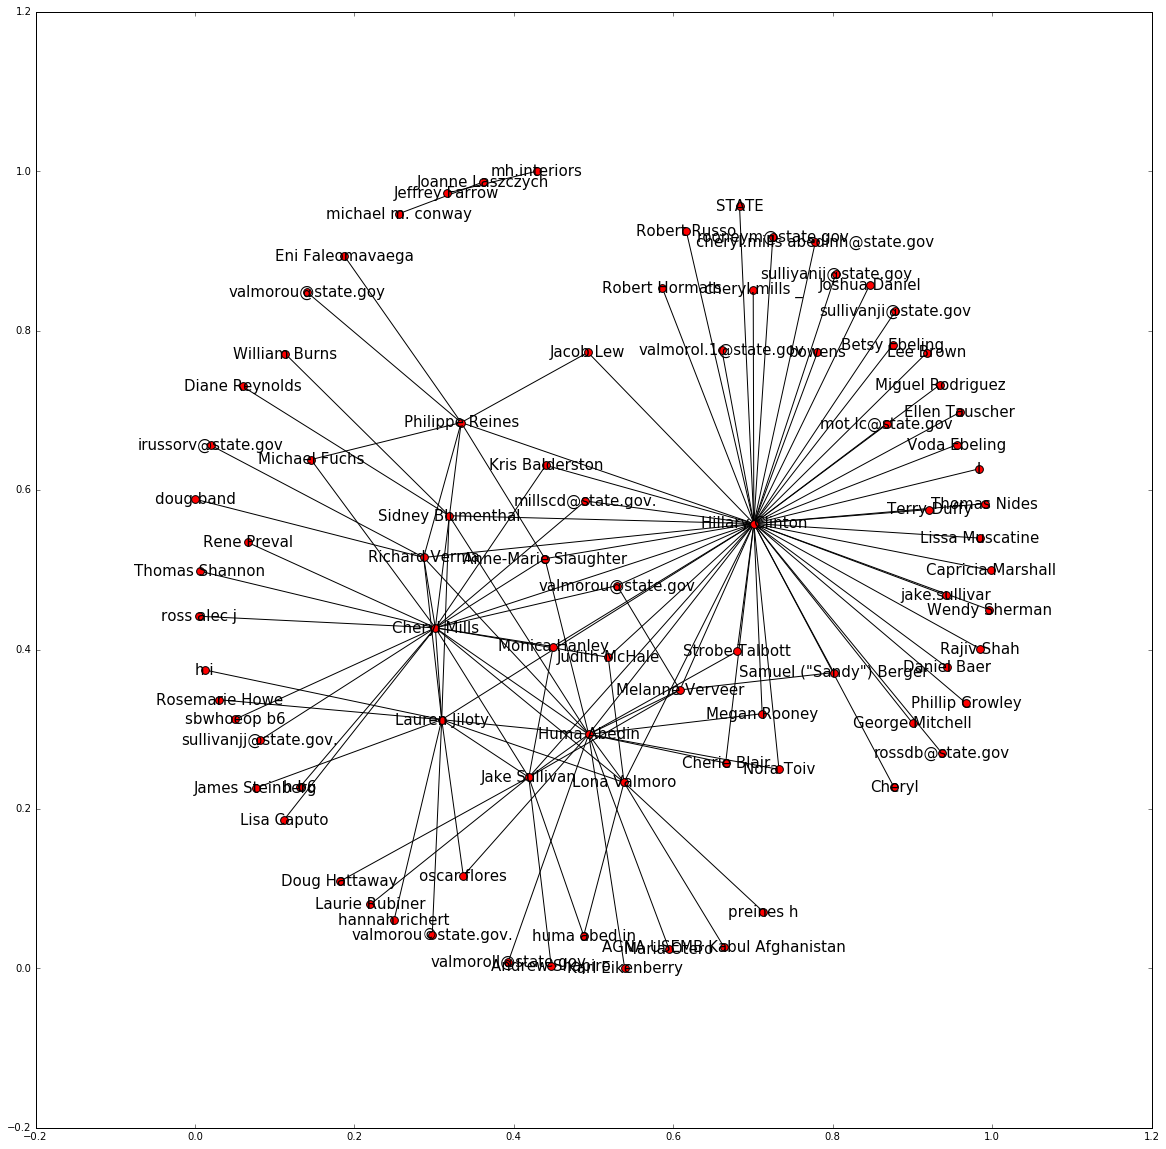

In [65]:
import networkx as nx
G=nx.from_pandas_dataframe(sample_emails, 'SenderPersonId', 'MetadataTo')
plt.figure(figsize=(20,20)) 
nx.draw_networkx(G, node_size=60, font_size=15)
plt.show()

### Community Detection

We start by building a graph object using all <code>emails</code> dataframe.

In [66]:
G=nx.from_pandas_dataframe(emails, 'SenderPersonId', 'MetadataTo')

In [67]:
from community import community_louvain

Then, we partition the resulting graph and find 12 different communities. Each Author is mapped to one community. Here, we display a mapping sample of 5 Authors.

In [68]:
partition = community_louvain.best_partition(G)
for index, (key, value) in enumerate(partition.items()):
    print('Author: ', key)
    print('Community: ', value)
    print('-----------------------\n')
    if index > 5:
        break

Author:  David Garten
Community:  0
-----------------------

Author:  Marty Torrey
Community:  1
-----------------------

Author:  Betsy Ebeling
Community:  2
-----------------------

Author:  sullivahu@state.gov
Community:  1
-----------------------

Author:  Barack Obama
Community:  1
-----------------------

Author:  rossdb@state.gov
Community:  0
-----------------------

Author:  jilotylc©state.gov.
Community:  0
-----------------------



We identify the number of authors and communities as follows:

In [69]:
num_authors = len(partition.keys())
num_communities = len(set(partition.values()))
print('Number of authors: ', num_authors)
print('Number of communities: ', num_communities)

Number of authors:  476
Number of communities:  11


In [70]:
def map_author_to_community(author):
    """
    Maps each author to the respective community
    
    Parameters: 
    author: author name
    return: author community
    """
    return partition[author]

Now, we map the authors to their respective communities

In [71]:
emails['Community'] = emails.apply(lambda row: map_author_to_community(row['SenderPersonId']), axis=1)
emails.head()

,MetadataTo,SenderPersonId,Community
Id,,,
1,Hillary Clinton,Jake Sullivan,8
3,Hillary Clinton,Cheryl Mills,2
4,Hillary Clinton,Cheryl Mills,2
5,Huma Abedin,Hillary Clinton,0
6,Robert Russo,Hillary Clinton,0


We create a column in the <code>emails</code> dataframe that contains the email text.

In [72]:
emails['Text'] = data
emails.head()

,MetadataTo,SenderPersonId,Community,Text
Id,,,,
1,Hillary Clinton,Jake Sullivan,8,What a wonderful strong and moving statement b...
3,Hillary Clinton,Cheryl Mills,2,Thx Original Message as our soldiers do. Think...
4,Hillary Clinton,Cheryl Mills,2,B5 B5 FYI Shea Peter T All ADS Aaron D. Snipe ...
5,Huma Abedin,Hillary Clinton,0,hrc memo syria aiding libya 030311. docx March...
6,Robert Russo,Hillary Clinton,0,Russorv state. gov htte maxbiumenthal. com1201...


Finally, we use the <code>create_wordcloud</code> function to find the most frequent words per community.

In [73]:
# iterate through all communities and find most frequent words
for community in set(partition.values()):
    # keep one community at a time
    emails_per_community = emails[emails['Community'] == community]['Text']
    corpus_per_community = emails_per_community.values.tolist()
    print('COMMUNITY:', community)
    # build community corpus
    corpus_per_community = ' '.join(corpus_per_community)
    # find most frequent words per community
    words = create_wordcloud(corpus_per_community, max_words=20, filter_stopwords=True, plot=False)
    print('Community: ', community, '\n', ' | '.join(words), '\n')

COMMUNITY: 0
Community:  0 
 State | Message | will | Original | Department | Case | Date | Doc | UNCLASSIFIED | government | new | time | also | US | call | said | President | one | work | Secretary 

COMMUNITY: 1
Community:  1 
 State | will | Obama | new | Case | Department | President | one | time | said | American | Date | government | UNCLASSIFIED | Doc | Republican | US | Message | party | year 

COMMUNITY: 2
Community:  2 
 State | will | Department | said | Message | Case | Secretary | Date | Clinton | UNCLASSIFIED | Doc | President | Original | new | Obama | one | also | government | US | time 

COMMUNITY: 3
Community:  3 
 will | State | Message | Original | said | call | Department | new | President | Case | Date | Secretary | talk | one | official | UNCLASSIFIED | Doc | also | security | time 

COMMUNITY: 4
Community:  4 
 State | will | Message | Clinton | Original | SECRETARY | said | QUESTION | Department | new | one | American | Case | time | year | know | Doc | also |

We see that the word clouds of each community cannot reveal the information captured by the topic modelling algorithm. For example, Libya and Israel are not mentioned in any of the community word clouds. Moreover, the word cloud of community 9 is (most probably) in Spanish. This information is not captured by LDA.